
LiH - Minimal Working Equivariant QML
Strategy: Simple circuit, energy first, then forces

Data: 2400 configurations

Train: 1920, Test: 480

PHASE 1: Training ENERGY only

  Step    0 | Train: 8.507478 | Test: 7.241652 | GradNorm: 10.0000
  Step   25 | Train: 0.343706 | Test: 0.304142 | GradNorm: 1.2861
  Step   50 | Train: 0.083464 | Test: 0.077157 | GradNorm: 0.5028
  Step   75 | Train: 0.008681 | Test: 0.007851 | GradNorm: 0.1716
  Step  100 | Train: 0.000329 | Test: 0.000388 | GradNorm: 0.0283
  Step  125 | Train: 0.000161 | Test: 0.000181 | GradNorm: 0.0119
  Step  150 | Train: 0.000126 | Test: 0.000147 | GradNorm: 0.0050
  Step  175 | Train: 0.000109 | Test: 0.000128 | GradNorm: 0.0030
  Step  200 | Train: 0.000101 | Test: 0.000117 | GradNorm: 0.0022
  Step  225 | Train: 0.000096 | Test: 0.000109 | GradNorm: 0.0015
  Step  250 | Train: 0.000094 | Test: 0.000105 | GradNorm: 0.0011
  Step  275 | Train: 0.000093 | Test: 0.000102 | GradNorm: 0.0008
  Step  300 | Train: 0.000092 | T

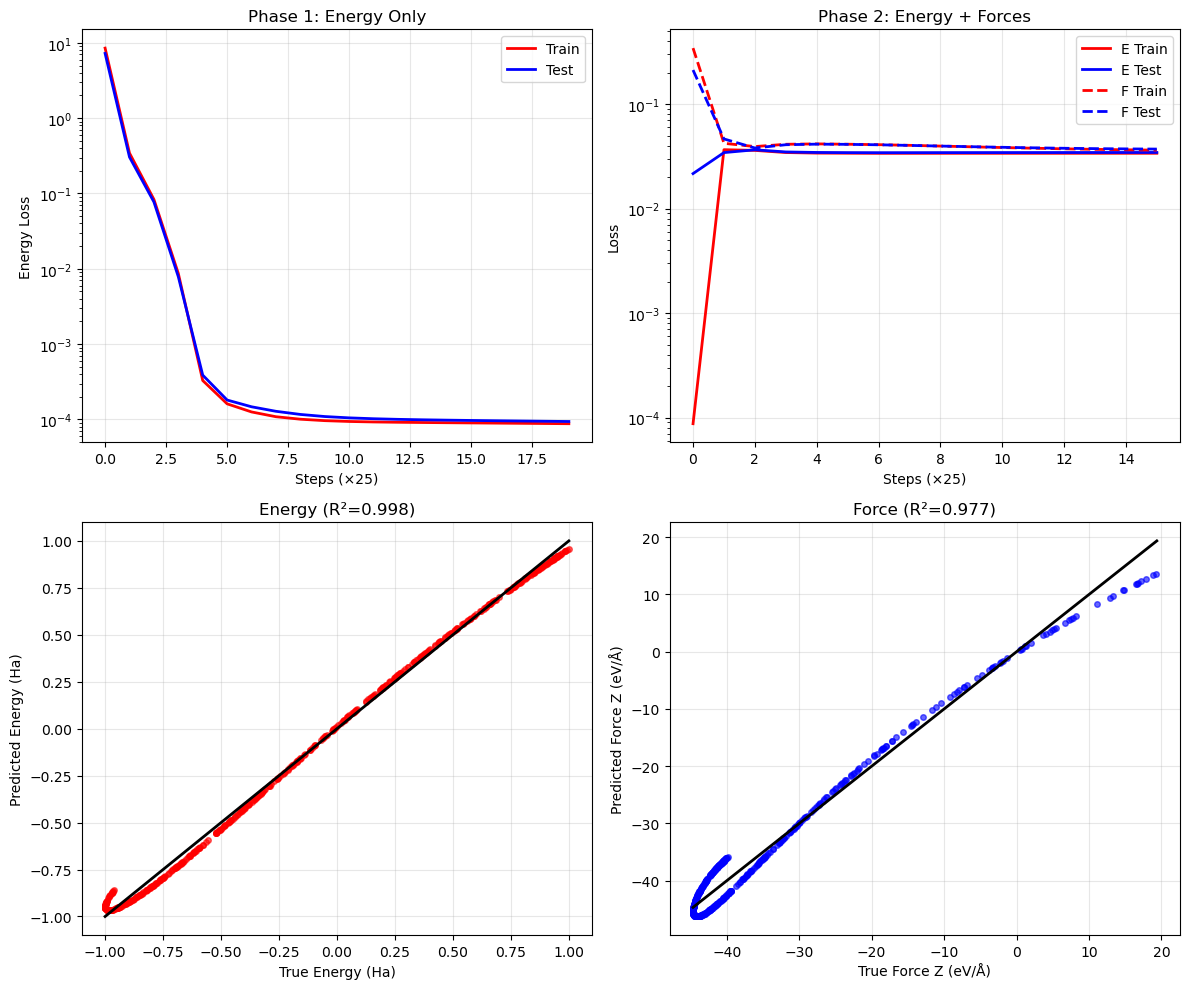

✓ Minimal working version complete!
✓ Two-phase training: energy first, then forces
✓ Simple circuit with basic gates only


In [8]:
import pennylane as qml
import numpy as np

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

#############################################################################################
# MINIMAL WORKING EQUIVARIANT QML FOR LiH
# Start simple: energy only, then add forces
#############################################################################################

print(f"\n{'='*70}")
print(f"LiH - Minimal Working Equivariant QML")
print(f"{'='*70}")
print(f"Strategy: Simple circuit, energy first, then forces")
print(f"{'='*70}\n")

n_qubits = 4
depth = 3

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax", diff_method="backprop")
def simple_qnn(positions, params):
    """
    Simple QNN that just encodes bond length.
    """
    weights = params["weights"]  # (depth, n_qubits, 3)
    
    # Single feature: bond length
    dist = jnp.linalg.norm(positions[1] - positions[0])
    
    # Initialize
    for i in range(n_qubits):
        qml.RY(0.5, wires=i)
    
    # Simple layers
    for layer in range(depth):
        # Encode distance
        for i in range(n_qubits):
            qml.RY(weights[layer, i, 0] * dist, wires=i)
        
        # Entangle
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        
        # More rotations
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 1], wires=i)
            qml.RY(weights[layer, i, 2], wires=i)
    
    # Simple measurement
    return qml.expval(qml.PauliZ(0) + qml.PauliZ(1) + qml.PauliZ(2) + qml.PauliZ(3))

#############################################################################################
# DATA LOADING
#############################################################################################

energy = np.load("eqnn_force_field_data_LiH/Energy.npy")
forces = np.load("eqnn_force_field_data_LiH/Forces.npy")
positions = np.load("eqnn_force_field_data_LiH/Positions.npy")

print(f"Data: {len(positions)} configurations\n")

# Normalize energies only
energy_scaler = MinMaxScaler((-1, 1))
if energy.ndim == 1:
    energy = energy.reshape(-1, 1)
energy_scaled = energy_scaler.fit_transform(energy).flatten()

forces_H = forces[:, 1:, :]
force_scaler = MinMaxScaler((-1, 1))
forces_z_only = forces_H[:, 0, 2].reshape(-1, 1)
forces_z_scaled = force_scaler.fit_transform(forces_z_only).flatten()

# Train/test split
np.random.seed(42)
indices_train = np.random.choice(len(positions), size=int(0.8 * len(positions)), replace=False)
indices_test = np.setdiff1d(np.arange(len(positions)), indices_train)

E_train = energy_scaled[indices_train]
E_test = energy_scaled[indices_test]
F_train = forces_z_scaled[indices_train]
F_test = forces_z_scaled[indices_test]
pos_train = jnp.array(positions[indices_train])
pos_test = jnp.array(positions[indices_test])

print(f"Train: {len(indices_train)}, Test: {len(indices_test)}\n")

#############################################################################################
# TRAINING - ENERGY ONLY FIRST
#############################################################################################

from jax.example_libraries import optimizers

vec_qnn = jax.vmap(simple_qnn, (0, None), 0)

@jax.jit
def energy_loss(params, loss_data):
    positions, E_target = loss_data
    E_pred = vec_qnn(positions, params)
    return jnp.mean((E_pred - E_target) ** 2)

def train_step_energy(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    loss, grads = jax.value_and_grad(energy_loss)(net_params, loss_data)
    
    # Check gradient health
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Simple clipping if needed
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Initialize
np.random.seed(42)
weights = jnp.array(np.random.normal(0, 0.1, (depth, n_qubits, 3)))
net_params = {"weights": weights}

print(f"{'='*70}")
print(f"PHASE 1: Training ENERGY only")
print(f"{'='*70}\n")

lr = 0.01
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(net_params)

energy_losses = []

for step in range(500):
    loss_data = (pos_train, E_train)
    loss, grad_norm, opt_state = train_step_energy(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test loss
        test_params = get_params(opt_state)
        E_pred_test = np.array(vec_qnn(pos_test, test_params))
        test_loss = np.mean((E_pred_test - E_test) ** 2)
        
        energy_losses.append([loss, test_loss])
        
        print(f"  Step {step:4d} | Train: {loss:.6f} | Test: {test_loss:.6f} | GradNorm: {grad_norm:.4f}")

print(f"\nEnergy training complete!\n")

# Get trained parameters
trained_params = get_params(opt_state)

# Predictions
E_pred_train = np.array(vec_qnn(pos_train, trained_params))
E_pred_test = np.array(vec_qnn(pos_test, trained_params))

print(f"Energy R² (train): {1 - np.var(E_pred_train - E_train) / np.var(E_train):.4f}")
print(f"Energy R² (test):  {1 - np.var(E_pred_test - E_test) / np.var(E_test):.4f}\n")

#############################################################################################
# PHASE 2: ADD FORCES
#############################################################################################

print(f"{'='*70}")
print(f"PHASE 2: Adding FORCES")
print(f"{'='*70}\n")

def energy_single(coords, params):
    return simple_qnn(coords, params)

def force_single(coords, params):
    grad_fn = jax.grad(energy_single, argnums=0)
    gradient = grad_fn(coords, params)
    return -gradient

vec_force = jax.vmap(force_single, (0, None), 0)

@jax.jit
def combined_loss(params, loss_data):
    positions, E_target, F_target = loss_data
    
    # Energy
    E_pred = vec_qnn(positions, params)
    E_loss = jnp.mean((E_pred - E_target) ** 2)
    
    # Forces - careful with gradients
    F_pred_full = vec_force(positions, params)
    F_pred_z = F_pred_full[:, 1, 2]
    F_loss = jnp.mean((F_pred_z - F_target) ** 2)
    
    # Check for NaN
    E_loss = jnp.where(jnp.isnan(E_loss), 1.0, E_loss)
    F_loss = jnp.where(jnp.isnan(F_loss), 1.0, F_loss)
    
    # Weighted combination - start with more energy weight
    lambda_E = 2.0
    lambda_F = 1.0
    
    total_loss = lambda_E * E_loss + lambda_F * F_loss
    
    return total_loss, (E_loss, F_loss)

def train_step_combined(step_i, opt_state, loss_data):
    net_params = get_params(opt_state)
    (loss, (E_loss, F_loss)), grads = jax.value_and_grad(combined_loss, has_aux=True)(net_params, loss_data)
    
    # Gradient norm
    grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree.leaves(grads) if g is not None))
    
    # Clip if very large
    if grad_norm > 10.0:
        grads = jax.tree.map(lambda g: g * (10.0 / grad_norm) if g is not None else g, grads)
        grad_norm = 10.0
    
    return float(loss), float(E_loss), float(F_loss), float(grad_norm), opt_update(step_i, grads, opt_state)

# Start from trained energy parameters
opt_state = opt_init(trained_params)

combined_losses = []

print("Training with energy + forces:")
for step in range(400):
    loss_data = (pos_train, E_train, F_train)
    loss, E_loss, F_loss, grad_norm, opt_state = train_step_combined(step, opt_state, loss_data)
    
    if step % 25 == 0:
        # Test
        test_params = get_params(opt_state)
        E_pred_test_val = np.array(vec_qnn(pos_test, test_params))
        F_pred_test_val = np.array(vec_force(pos_test, test_params))[:, 1, 2]
        
        E_test_loss = np.mean((E_pred_test_val - E_test) ** 2)
        F_test_loss = np.mean((F_pred_test_val - F_test) ** 2)
        
        combined_losses.append([E_loss, E_test_loss, F_loss, F_test_loss])
        
        print(f"  Step {step:4d} | E: {E_loss:.4f}/{E_test_loss:.4f} | "
              f"F: {F_loss:.4f}/{F_test_loss:.4f} | GradNorm: {grad_norm:.4f}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"{'='*70}\n")

#############################################################################################
# FINAL EVALUATION
#############################################################################################

final_params = get_params(opt_state)

# Predictions on all data
E_pred_all = np.array(vec_qnn(jnp.array(positions), final_params))
F_pred_all = np.array(vec_force(jnp.array(positions), final_params))
F_pred_all_z = F_pred_all[:, 1, 2]

# Post-correction
print("Post-correction...")

# Energy
def corr_E(E, a, b, c):
    return a * E**2 + b * E + c

try:
    popt_E, _ = curve_fit(corr_E, E_pred_all[indices_train], E_train)
    E_pred_corr = corr_E(E_pred_all, *popt_E)
    print(f"Energy: a={popt_E[0]:.4f}, b={popt_E[1]:.4f}, c={popt_E[2]:.4f}")
except:
    E_pred_corr = E_pred_all
    print("Energy: No correction")

# Force
try:
    from sklearn.linear_model import LinearRegression
    lr_model = LinearRegression()
    lr_model.fit(F_pred_all_z[indices_train].reshape(-1, 1), F_train)
    F_pred_corr = lr_model.predict(F_pred_all_z.reshape(-1, 1)).flatten()
    print(f"Force: slope={lr_model.coef_[0]:.4f}, intercept={lr_model.intercept_:.4f}")
except:
    F_pred_corr = F_pred_all_z
    print("Force: No correction")

# Inverse transform
E_pred_final = energy_scaler.inverse_transform(E_pred_corr.reshape(-1, 1)).flatten()
F_pred_final = force_scaler.inverse_transform(F_pred_corr.reshape(-1, 1)).flatten()

E_true = energy_scaler.inverse_transform(energy_scaled.reshape(-1, 1)).flatten()
F_true = forces_H[:, 0, 2]

# Metrics
E_mae = np.mean(np.abs(E_pred_final[indices_test] - E_true[indices_test]))
E_rmse = np.sqrt(np.mean((E_pred_final[indices_test] - E_true[indices_test]) ** 2))
E_r2 = 1 - np.sum((E_pred_final[indices_test] - E_true[indices_test])**2) / np.sum((E_true[indices_test] - E_true[indices_test].mean())**2)

F_mae = np.mean(np.abs(F_pred_final[indices_test] - F_true[indices_test]))
F_rmse = np.sqrt(np.mean((F_pred_final[indices_test] - F_true[indices_test]) ** 2))
F_r2 = 1 - np.sum((F_pred_final[indices_test] - F_true[indices_test])**2) / np.sum((F_true[indices_test] - F_true[indices_test].mean())**2)

print(f"\n{'='*70}")
print(f"FINAL RESULTS")
print(f"{'='*70}")
print(f"Energy:")
print(f"  MAE:  {E_mae:.6f} Ha ({E_mae*27.2114:.3f} eV)")
print(f"  RMSE: {E_rmse:.6f} Ha ({E_rmse*27.2114:.3f} eV)")
print(f"  R²:   {E_r2:.4f}")
print(f"\nForce Z:")
print(f"  MAE:  {F_mae:.4f} eV/Å")
print(f"  RMSE: {F_rmse:.4f} eV/Å")
print(f"  R²:   {F_r2:.4f}")
print(f"{'='*70}\n")

#############################################################################################
# PLOTS
#############################################################################################

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Energy training
energy_losses = np.array(energy_losses)
axes[0, 0].plot(energy_losses[:, 0], 'r-', lw=2, label='Train')
axes[0, 0].plot(energy_losses[:, 1], 'b-', lw=2, label='Test')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Steps (×25)')
axes[0, 0].set_ylabel('Energy Loss')
axes[0, 0].set_title('Phase 1: Energy Only')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Combined training
if len(combined_losses) > 0:
    combined_losses = np.array(combined_losses)
    axes[0, 1].plot(combined_losses[:, 0], 'r-', lw=2, label='E Train')
    axes[0, 1].plot(combined_losses[:, 1], 'b-', lw=2, label='E Test')
    axes[0, 1].plot(combined_losses[:, 2], 'r--', lw=2, label='F Train')
    axes[0, 1].plot(combined_losses[:, 3], 'b--', lw=2, label='F Test')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xlabel('Steps (×25)')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Phase 2: Energy + Forces')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Energy predictions
axes[1, 0].plot(E_true[indices_test], E_pred_final[indices_test], 'ro', alpha=0.6, ms=4)
axes[1, 0].plot([E_true.min(), E_true.max()], [E_true.min(), E_true.max()], 'k-', lw=2)
axes[1, 0].set_xlabel('True Energy (Ha)')
axes[1, 0].set_ylabel('Predicted Energy (Ha)')
axes[1, 0].set_title(f'Energy (R²={E_r2:.3f})')
axes[1, 0].grid(True, alpha=0.3)

# Force predictions
axes[1, 1].plot(F_true[indices_test], F_pred_final[indices_test], 'bo', alpha=0.6, ms=4)
axes[1, 1].plot([F_true.min(), F_true.max()], [F_true.min(), F_true.max()], 'k-', lw=2)
axes[1, 1].set_xlabel('True Force Z (eV/Å)')
axes[1, 1].set_ylabel('Predicted Force Z (eV/Å)')
axes[1, 1].set_title(f'Force (R²={F_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('LiH_minimal_working.png', dpi=300)
plt.show()

print("✓ Minimal working version complete!")
print("✓ Two-phase training: energy first, then forces")
print("✓ Simple circuit with basic gates only")